In [24]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
from pathlib import Path

from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP

In [25]:
data_name = "DS03"

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data

In [26]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [27]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [28]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

In [29]:
performs_train = {name: 
    {int(unit): hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_alias
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Create component (base) models

In [30]:
perform_name = 'T48'
trian_units = range(1,9)
eval_units = range(9,10)

t_datas = [time_train[unit] for unit in eval_units]
s_datas = [performs_train['T48'][unit] for unit in eval_units]


In [31]:
base_models = []
for unit, perform in performs_train[perform_name].items():
	if unit not in trian_units:
		continue
	best_model = NModel()
	best_model.load_state_dict(
		torch.load(states_dir /perform_name/f'unit_{unit}'/ "best_model.pt", map_location=device)
	)
	best_model.to(device)
	base_models.append(best_model)

## Train Particle Filter Net

In [32]:
n_epochs = 10000
start_idx = 1  

In [33]:
eols = [torch.tensor(t_data[-1], dtype=torch.float32) for t_data in t_datas]

net = ParticleFilterMLP(state_dim=5,hidden_dims=[2, 128,128, 32, 2])
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


n_loss = 0
total_loss = 0
bckp_freq = 30
losses = []
epoachs = []
for epoch in range(n_epochs):
    #print(f"\n===== Epoch {epoch:03d} =====")

    # ----------------------------------------
    # Reset PF but reuse the SAME NN
    # ----------------------------------------
    pf = ParticleFilterModel(
        base_models=base_models,
        net=net,
        max_life=100.0,
        n_particles=800,
        multiply_scale=0.01,
        name="T48",
    ).train()
    
    
    optimizer.zero_grad()
    
    for t_data, s_data,eol in zip(t_datas, s_datas,eols):
        for k in range(start_idx, len(t_data)):#
            t_obs = torch.tensor(t_data[:k], dtype=torch.float32)
            s_obs = torch.tensor(s_data[:k], dtype=torch.float32)

            # --- PF step (returns loss) ---
            mixture_dist = pf.step(
                t_obs=t_obs,
                s_obs=s_obs,
            )
            nll = mixture_dist.rul_nll(eol)
            #mse = mixture_dist.rul_mse(eol)
            total_loss = total_loss + nll
            n_loss+=1

    # ----------------------------------------
    # Backprop ONCE per epoch
    # ----------------------------------------
    if epoch % bckp_freq == 0:
        total_loss /= n_loss
        total_loss.backward()
        optimizer.step()
        print(f"[Epoch {epoch:03d}] total_loss = {total_loss.item():.2f}")
        losses.append(total_loss.item())
        epoachs.append(epoch)
        n_loss = 0
        total_loss = 0
    net=pf.net

    


[Epoch 000] total_loss = 3.82
[Epoch 030] total_loss = 3.83
[Epoch 060] total_loss = 3.82
[Epoch 090] total_loss = 3.82
[Epoch 120] total_loss = 3.83
[Epoch 150] total_loss = 3.81
[Epoch 180] total_loss = 3.82
[Epoch 210] total_loss = 3.83
[Epoch 240] total_loss = 3.82
[Epoch 270] total_loss = 3.81
[Epoch 300] total_loss = 3.81
[Epoch 330] total_loss = 3.82
[Epoch 360] total_loss = 3.83
[Epoch 390] total_loss = 3.83
[Epoch 420] total_loss = 3.82
[Epoch 450] total_loss = 3.85
[Epoch 480] total_loss = 3.82
[Epoch 510] total_loss = 3.81
[Epoch 540] total_loss = 3.82
[Epoch 570] total_loss = 3.83
[Epoch 600] total_loss = 3.79
[Epoch 630] total_loss = 3.81
[Epoch 660] total_loss = 3.81
[Epoch 690] total_loss = 3.82
[Epoch 720] total_loss = 3.82
[Epoch 750] total_loss = 3.81
[Epoch 780] total_loss = 3.82
[Epoch 810] total_loss = 3.81
[Epoch 840] total_loss = 3.83
[Epoch 870] total_loss = 3.82
[Epoch 900] total_loss = 3.82
[Epoch 930] total_loss = 3.81
[Epoch 960] total_loss = 3.81
[Epoch 990

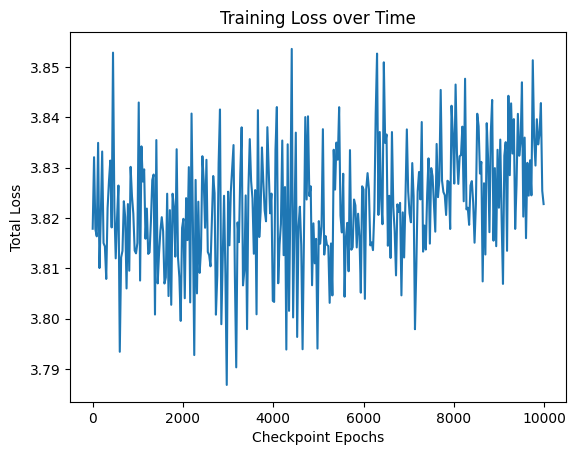

In [34]:
from matplotlib import pyplot as plt
plt.plot(epoachs,losses)
plt.xlabel('Checkpoint Epochs')
plt.ylabel('Total Loss')
plt.title('Training Loss over Time')
plt.show()

## Run Particle Filter with (leraned net)

Save plots

In [35]:
t_grid = np.linspace(0.1, 100, 400)
s_grid = np.linspace(0.0, 1.0, 300)


frames = []
pf.eval()
for k in range(start_idx, len(t_data)):#
	t_obs = torch.tensor(t_data[:k], dtype=torch.float32)
	s_obs = torch.tensor(s_data[:k], dtype=torch.float32)

	# --- PF step (returns loss) ---
	pf.step(
		t_obs=t_obs,
		s_obs=s_obs,
	)
	
	# --- render frame ---
	fig, ax = plt.subplots(figsize=(10, 8))
	pf.plot(
	    ax=ax,
	    t_grid=t_grid,
	    s_grid=s_grid,
	    t_obs=t_data[:k],
	    s_obs=s_data[:k],
	    title=f"Epoch {epoch} | step {k}",
	)

	fig.canvas.draw()
	frame = np.asarray(fig.canvas.renderer.buffer_rgba())
	plt.close(fig)
	frames.append(frame)

/var/folders/hl/2v5kr9994fl_j6sv_4mt0bn00000gn/T/ipykernel_93107/4288962885.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()


## Save video

In [36]:
import imageio
video_path = f"pf_{perform_name}_unit{eval_units[0]}.mp4"

with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
    for frame in frames:
        writer.append_data(frame)

print(f"🎬 Video saved to {video_path}")

🎬 Video saved to pf_T48_unit9.mp4
